In [1]:
import pandas as pd
import numpy as np
import geopandas
import matplotlib.colors as colors
import math
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import plotly.express as px

from module.variables import *
from module.functions import *

In [2]:
region_to_name = pd.DataFrame([uk_regions, uk_names]).T
region_to_name.columns = ["ABR", "NAME_1"]


In [3]:
providers = pd.DataFrame(uk_data).T
providers.columns = ["Providers", "NAME_1", "Population", "Compensation1"]
providers["Compensation1"] = providers["Compensation1"].astype("float")

In [4]:
state_to_state = pull_all(10, [2017, 2018], uk_regions, "UK").mean()
state_to_state = pd.DataFrame(state_to_state)
state_to_state.reset_index(inplace=True)
state_to_state.columns = ["ABR", "Interest_18"]
state_to_state = state_to_state.merge(region_to_name, on="ABR")
states = geopandas.read_file('GBR_adm/GBR_adm1.shp')
states = states.merge(state_to_state, on="NAME_1")
states = states.merge(providers, on="NAME_1")
states["Rate_100k_18"] = states["Providers"]/states["Population"] * 100000
states["Rate_100k_18"] = states["Rate_100k_18"].astype('float64')
states["Need_18"] = states["Interest_18"]/states["Rate_100k_18"]


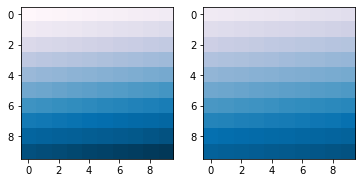

In [5]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list('trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),cmap(np.linspace(minval, maxval, n)))
    return new_cmap

arr = np.linspace(0, 50, 100).reshape((10, 10))
fig, ax = plt.subplots(ncols=2)
cmap = plt.get_cmap('PuBu')
new_cmap = truncate_colormap(cmap, 0.1, 0.9)
ax[0].imshow(arr, interpolation='nearest', cmap=cmap)
ax[1].imshow(arr, interpolation='nearest', cmap=new_cmap)
plt.show()

In [6]:
x = states["Need_18"]
y = states["Compensation1"]

In [7]:
x

0    2.495187
1    7.132560
2    1.672923
3    7.742553
Name: Need_18, dtype: float64

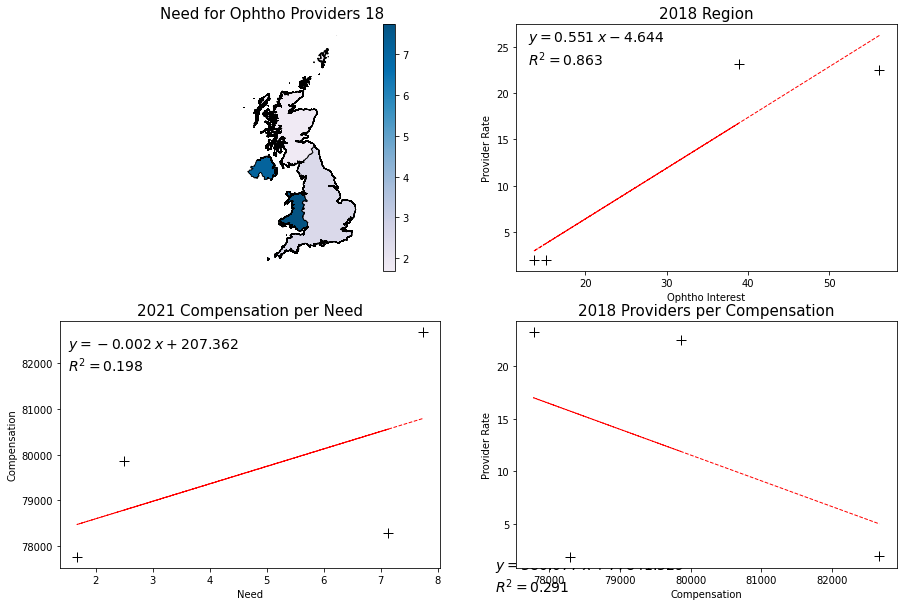

In [10]:
# Geo Map by State
fig, ((ax1, ax3), (ax2, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
ax1.axis('off')
ax1.set_title('Need for Ophtho Providers 18', fontdict={'fontsize': '15', 'fontweight' : '3'})
states.plot(column='Need_18',
          cmap=new_cmap,
          linewidth=0.9,
            ax=ax1,
            edgecolor='0',
            legend=True)

#Scatter by State
ax3.set_title('2018 Region', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax3.set_xlabel("Ophtho Interest")
ax3.set_ylabel("Provider Rate")
x = states["Interest_18"]
y = states["Rate_100k_18"]

ax3.plot(x,y,"+", 
         ms=10, 
         mec="k",)

z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)

ax3.plot(x, y_hat, 
         "r--",
         lw=1)
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
ax3.text(13, 27, text,
     fontsize=14, verticalalignment='top')

#Scatter by State
ax4.set_title('2018 Providers per Compensation', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax4.set_xlabel("Compensation")
ax4.set_ylabel("Provider Rate")
x = states["Compensation1"]
y = states["Rate_100k_18"]

ax4.plot(x,y,"+", 
         ms=10, 
         mec="k",)

z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)

ax4.plot(x, y_hat, 
         "r--",
         lw=1)
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
ax4.text(71200, 19.5, text,
     fontsize=14)


#Scatter by State
ax2.set_title('2021 Compensation per Need', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax2.set_xlabel("Need")
ax2.set_ylabel("Compensation")
x = states["Need_18"]
y = states["Compensation1"]

ax2.plot(x,y,"+", 
         ms=10, 
         mec="k",)

z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)

ax2.plot(x, y_hat, 
         "r--",
         lw=1)
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
ax2.text(9, 77000, text,
     fontsize=14)


fig.savefig('Figures/UK.png')

Text(13, 27, '$y=0.551\\;x-4.644$\n$R^2 = 0.863$')

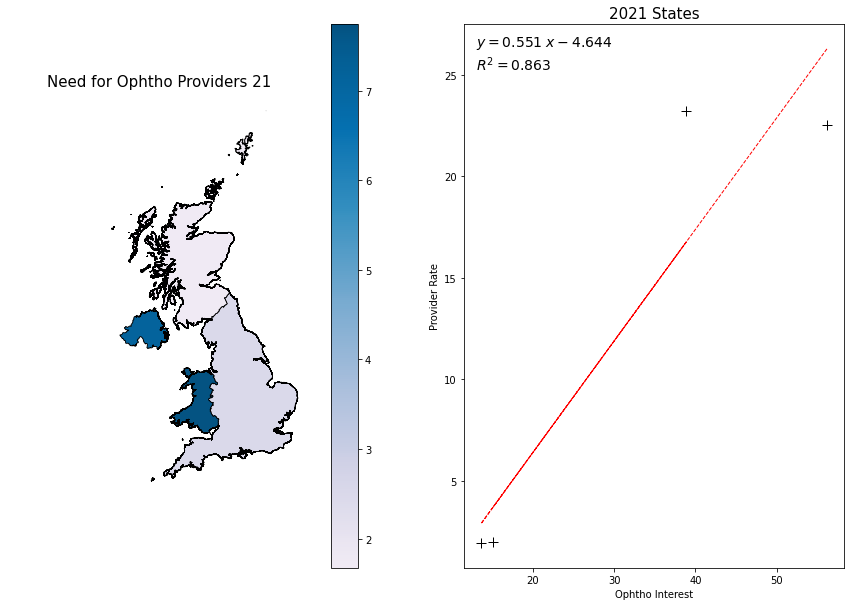

In [9]:
# Geo Map by State
fig, ((ax1, ax3)) = plt.subplots(1, 2, figsize=(15, 10))
ax1.axis('off')
ax1.set_title('Need for Ophtho Providers 21', fontdict={'fontsize': '15', 'fontweight' : '3'})
states.plot(column='Need_18',
          cmap=new_cmap,
          linewidth=0.9,
            ax=ax1,
            edgecolor='0',
            legend=True)

#Scatter by State
ax3.set_title('2021 States', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax3.set_xlabel("Ophtho Interest")
ax3.set_ylabel("Provider Rate")
x = states["Interest_18"]
y = states["Rate_100k_18"]

ax3.plot(x,y,"+", 
         ms=10, 
         mec="k",)

z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)

ax3.plot(x, y_hat, 
         "r--",
         lw=1)
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
ax3.text(13, 27, text,
     fontsize=14, verticalalignment='top')


# fig.savefig('Figures/2021.png')